## **Rapport de modélisation : système de vote entre classificateurs**

## *Pré-requis : installations et import de modules*

In [ ]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, make_scorer, classification_report, precision_score, recall_score, f1_score

import nltk
nltk.download('all');

import tensorflow as tf

from importlib.util import find_spec
import os
if find_spec("fasttext") is None:
  print("Module fasttext is unavailable - Proceeding to its installation")
  os.system("pip install fasttext")
import fasttext

if find_spec("gensim") is None:
  print("Module gensim is unavailable - Proceeding to its installation")
  os.system("pip install gensim")
import gensim

if find_spec("sentencepiece") is None:
  print("Module sentencepiece is unavailable - Proceeding to its installation")
  os.system("pip install sentencepiece")
import sentencepiece

import packaging.version as pkgver
import importlib
if find_spec("transformers") is None:
  print("Module transformers is unavailable - Proceeding to its installation")
  os.system("pip install transformers==4.29.0")
else:
  import transformers
  if pkgver.parse(transformers.__version__) < pkgver.parse("4.29.0"):
    print("Module transformers version is too old - Proceeding to its ugrade")
    os.system("pip install transformers==4.29.0")
    importlib.reload(transformers)

!pip install torch --upgrade

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

## *Import des fichiers*

### *Point de montage et définition des répertoires utiles*

In [ ]:
# Open a session: initialize a few practical constants, mount share drive
from google.colab import drive
import os.path

DRIVE_PATH = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten"
CSV_FILE_DIR = os.path.join(DRIVE_PATH, "CSV_avec_traduction")
IMG_DIR = os.path.join(DRIVE_PATH, "train_test/images")
IMG_TRAIN_DIR = os.path.join(IMG_DIR, "image_train")

MODELS_DIR = os.path.join(DRIVE_PATH, "models")
SAVED_MODELS_DIR = os.path.join(MODELS_DIR, "saved_models")
MODEL_RESULTS_DIR = os.path.join(MODELS_DIR, "model_results")

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


### *Chargement des données (variables explicatives et cibles)*

In [ ]:
# Load train CSV files
df = pd.read_csv(os.path.join(CSV_FILE_DIR, "df_avec_traduction.csv"))

# Extraction of the target data
target_labels = df['Labels']
unique_categories = np.array(target_labels.drop_duplicates().sort_values())

## *Pré-traitement : mise en minuscules et retrait des mots-stops*

In [ ]:
from nltk.corpus import stopwords

designations_descriptions = df['designe_decrit'].str.lower()
stop = stopwords.words('french')
designations_descriptions = designations_descriptions.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

df["preprocessed_text"] = designations_descriptions

## *Découpage en données d'entraînement et données de test*

Ce découpage est effectué dès ici pour assurer une homogénéité dans l'ensemble du notebook

In [ ]:
def project_train_test_split(*data, stratify=None):
  if stratify is None:
    stratify = target_labels
  return train_test_split(
      *data, stratify=stratify, train_size=0.67, random_state=42
  )

In [ ]:
# Use stratified splitting as the target product categories are populated in quite an imbalanced fashion
df_train, df_test, y_train, y_test = project_train_test_split(df, target_labels)

# By default, train and test features are built from column "preprocessed_text" alone
X_train = df_train["preprocessed_text"]
X_test = df_test["preprocessed_text"]

## *Définition de fonctions d'affichage et d'analyse*

### *Affichage des scores d'un modèle en fonction de ses hyperparamètres*

In [ ]:
# Function to plot cross-validation grid search results
from sklearn.preprocessing import LabelEncoder

def plot_cvgrid_scores(
    grid,
    n_cols=3,
    cell_size=6,
    remove_one_val_params=True,
    train_test_diff=False,
    secondary_test_axis=False,
    equal_x_y_limits=False
):
  """
  Plot a grid search's score results. Several subplots will be produced, each with a scatter of the same data.
  The difference between the subplots will be that dots will be colored according to a different hyperparameter.
  The X axis of each subplot will represent the score or mean score obtained over test data.
  The Y axis content will depend of argument train_test_diff (see below).

  Arguments:
  grid (DataFrame): A DataFrame with columns:
                    - "mean_train_score" or "train_score"
                    - "mean_test_score" or "test_score"
                    - a series of columns named "param_<hyperparameter name>"
  n_cols (int, default = 3): Maximum number of subplots per row. New rows are created as necessary.
  cell_size (int, default = 6): Width and height of each subplot.
  remove_one_val_params (bool, default = True): When only one value is available for a given hyperparameter,
                                                discard it, i.e. do not add a subplot for it
  train_test_diff (bool, default = False): If True, plot the (mean) train minus to (mean) test score along the Y axis.
                                          If false, plot the (mean) test score along the Y axis and add
                                                    a dashed, black line to represent identity.
  secondary_test_axis (bool, default = False): If True, set a secondary X axis at the top of each scatter to represent
                                               the (mean) test score relative to the maximum of all plotted (mean) test scores.
  equal_x_y_limits (bool, default = False): If True, force X and Y ranges to be equal to each other.
                                            Mostly useful when train_test_diff = False.
  """
  train_scores = grid["mean_train_score"] if "mean_train_score" in grid.columns else grid["train_score"]
  test_scores = grid["mean_test_score"] if "mean_test_score" in grid.columns else grid["test_score"]

  if train_test_diff:
    y_axis_scores = train_scores - test_scores
    y_label = "Train - test score difference"
  else:
    y_axis_scores = train_scores
    y_label = "Train score"

  param_cols = sorted(c for c in grid.columns if c.startswith("param_"))
  if remove_one_val_params:
    param_cols = [c for c in param_cols if grid[c].drop_duplicates().count() > 1]

  param_names = [p[6:] for p in param_cols]
  n_params = len(param_names)

  n_rows = (n_params - 1) // n_cols + 1
  fig = plt.figure(figsize=(n_cols * cell_size, n_rows * cell_size))
  plt.subplots_adjust(bottom=-0.05, left=-0.05)
  i_fig = 0
  for param_col, param_name in zip(param_cols, param_names):
    i_fig += 1
    ax = fig.add_subplot(n_rows, n_cols, i_fig)

    param_values = grid[param_col]
    le = LabelEncoder()
    encoded_param_values = le.fit_transform(param_values)
    scatter = plt.scatter(test_scores, y_axis_scores, c=encoded_param_values, cmap=plt.cm.Spectral)

    if equal_x_y_limits:
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()
      xylim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
      ax.set_xlim(xylim)
      ax.set_ylim(xylim)

    if not train_test_diff:
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()
      xylim = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
      ax.plot(xylim, xylim, ':k')
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)

    ax.set_xlabel("Test score")
    ax.set_ylabel(y_label)
    ax.set_title("Parameter '{}'".format(param_name))
    ax.legend(handles=scatter.legend_elements()[0], labels=le.classes_.tolist());

    if secondary_test_axis:
      ax2 = ax.twiny()
      ax2.set_xlim([x / test_scores.max() for x in ax.get_xlim()])
      ax2.set_xlabel("Relative to the maximum test score");


### *Affichage de différents scores par valeur-cible et par classificateur*

In [ ]:
# Plot scores for the different product categories and classifiers
def plot_scores_per_cat_mdl(ordered_categories, scores_per_cat_and_mdl, max_columns=3, cell_width=7.5, cell_height=5, kwargs_per_mdl=None):
  """
  Plot different scores per target category as obtained with several models. One subplot will be created for each score type,
  and the scores of the different models will be plotted in each of them.
  Arguments:
    ordered_categories: sequence of target categories
    scores_per_cat_and_mdl: dictionary of form {"score name": {"model name": [score for target 1, score for target 2...]}}.
                            The scores in each sequence must appear in the same order as items in ordered_categories
    max_columns: maximum subplot columns (defaults to 3)
    cell_width: width of each "cell"/subplot (defaults to 7.5)
    cell_height: height of each "cell"/subplot (defaults to 7.5)
    kwargs_per_mdl: if not None, a dictionary of form {"model name": {"pyplot.plot() kwarg name": value}}
  """
  n_scores = len(scores_per_cat_and_mdl)
  n_rows = 1 + (n_scores - 1) // max_columns
  n_columns = min(n_scores, max_columns)
  plt.figure(figsize=(cell_width * n_columns, cell_height * n_rows))

  if kwargs_per_mdl is None:
    kwargs_per_mdl = {}

  i_fig = 0
  for score_name, scores_per_mdl in scores_per_cat_and_mdl.items():
    i_fig += 1
    plt.subplot(n_rows, n_columns, i_fig)
    for mdl_name, score_per_cat in scores_per_mdl.items():
      plt.plot(ordered_categories, score_per_cat, label=mdl_name, **kwargs_per_mdl.get(mdl_name, {}))
    plt.xticks(rotation=90)
    plt.ylabel("{} score".format(score_name))
    plt.title("{} score per category and classifier".format(score_name))
    plt.legend()


### *Affichage de matrices de confusion*

In [ ]:
from matplotlib.colors import LogNorm

def plot_confusion_matrices(y_true, y_pred_per_mdl, ordered_categories=None, subplot_size=8, subplot_adjust_kwargs=None, sns_kwargs=None, log_scale=True, log_vmin=0.1, log_vmax=25e3):
  """
  Plot confusion matrices for different models. Plots will be vertically aligned.
  Arguments:
    y_true: true categories
    y_pred_per_mdl: dictionary of form {"model name": [predicted category 1, predicted category 2, ...]}
    ordered_categories: if provided, sequence of target categories in the desired display order. Otherwise, y_true will be used.
    subplot_size: size (width and height) of each subplot
    subplot_adjust_kwargs: kwargs to be passed to function pyplot.subplot_adjust. Defaults to {"bottom": -0.08}.
    sns_kwargs: if provided, will complete and/or override the following Seaborn display kwargs:
                - xticklabels = ordered_categories (or unique values in y_true)
                - yticklabels = ordered_categories (or unique values in y_true)
                - square = True
                - cbar_kws = {"shrink": 0.75}
                - cmap = plt.cm.plasma
                - log scale tuning (see following arguments)
    log_scale: if True, display the matrix in logarithmic scale. Defaults to True.
    log_vmin: if log_scale = True, minimum value to display. Defaults to 0.1.
    log_vmax: if log_scale = True, minimum value to display. Defaults to 25,000.
  """
  if ordered_categories is None:
    ordered_categories = np.unique(y_pred)

  kwargs = {
      "xticklabels": ordered_categories,
      "yticklabels": ordered_categories,
      "square": True,
      "cbar_kws": {"shrink": 0.75},
      "cmap": plt.cm.plasma,
  }
  if log_scale:
    kwargs["norm"] = LogNorm(vmin=log_vmin, vmax=log_vmax, clip=log_vmin)
  if sns_kwargs is not None:
    kwargs.update(sns_kwargs)

  if subplot_adjust_kwargs is None:
    subplot_adjust_kwargs = {"bottom": -0.08}

  n_subplots = len(y_pred_per_mdl)
  plt.figure(figsize=(subplot_size, subplot_size * n_subplots))
  plt.subplots_adjust(**subplot_adjust_kwargs)
  i_fig = 0
  for name, y_pred in y_pred_per_mdl.items():
    i_fig += 1
    plt.subplot(n_subplots, 1, i_fig)
    cm = confusion_matrix(y_true, y_pred, labels=ordered_categories)
    sns.heatmap(cm, **kwargs)
    plt.xlabel("Predicted categories")
    plt.ylabel("True categories")
    plt.title("Model = {}".format(name));


## *Classification à plusieurs modèles*

### *Déclaration d'une classe Python : empilement de probabilités par classe telles que produites par des modèles*

In [ ]:
class PredictProbaStack:

  def __init__(self):
    self.classes_ = None
    self.classifier_names = []
    self.__probas = []
    self.__obs_count = None

  def add_probas(self, clf_name, probas, classes):
    if self.classes_ is None:
      self.classes_ = np.array(classes)
    elif len(classes) != len(self.classes_):
        raise ValueError(
            "Incorrect item count in argument 'classes': expected {}, got {}"
            .format(len(self.classes_), len(classes))
        )

    classes = list(classes)
    try:
      class_indexes = np.array([classes.index(c) for c in self.classes_])
    except ValueError:
      raise ValueError(
          "Found values in argument 'classes' that were not provided in "
          "previous calls"
      )

    if not isinstance(probas, np.ndarray):
      probas = np.array(probas)
    if len(probas.shape) != 2:
      raise ValueError(
          "Incorrect shape for argument 'probas': expected a 2D array"
      )
    if probas.shape[1] != len(self.classes_):
      raise ValueError(
          "Incorrect shape for argument 'probas': expected length of 2nd axis "
          "to be {}, got {}".format(len(self.classes_), probas.shape[1])
      )
    if self.__obs_count is None:
      self.__obs_count = probas.shape[0]
    elif probas.shape[0] != self.__obs_count:
      raise ValueError(
          "Incorrect shape for argument 'probas': expected length of 1st axis "
          "to be {}, got {}".format(len(self.__obs_count), probas.shape[0])
      )

    self.__probas.append(probas[:, class_indexes])
    self.classifier_names.append(clf_name)

  def __check_probas_available(self):
    if self.__probas is None:
      raise ValueError(
          "No probability available. Did you previously call 'add_probas'?"
      )

  def predict_proba(self, weights=None):
    self.__check_probas_available()

    return np.average(self.__probas, axis=0, weights=weights)

  def predict(self, voting="soft", weights=None):
    self.__check_probas_available()

    if voting == "soft":
      return self.classes_[self.predict_proba(weights).argmax(axis=1)]
    elif voting == "hard":
      if weights is None:
        weights = np.ones(len(self.__probas))
      scores = np.zeros((self.__obs_count, len(self.classes_)))
      obs_indexes = list(range(self.__obs_count))
      for probas, weight in zip(self.__probas, weights):
        scores[obs_indexes, probas.argmax(axis=1)] += weight

      return self.classes_[scores.argmax(axis=1)]
    else:
      raise ValueError(
          "Unknown voting mode: expected 'soft' or 'hard, got '{}'"
          .format(voting)
      )

  def clf_predict_proba(self, clf_name):
    self.__check_probas_available()

    try:
      clf_index = self.classifier_names.index(clf_name)
    except ValueError:
      raise ValueError("Classifier '{}' not recognized".format(clf_name))

    return self.__probas[clf_index]

  def clf_predict(self, clf_name):
    return self.classes_[self.clf_predict_proba(clf_name).argmax(axis=1)]


### *Chargement des classificateurs individuels*

In [ ]:
from transformers import CamembertTokenizer

# tfidf_vectorizer = TfidfVectorizer().fit(X_train)
camembert_tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# fasttext_categories = [
#     "__label__" + label.replace(" ", "-").replace(".", "").replace(",", "")
#     for label in unique_categories
# ]
# original_to_fasttext_category = dict(zip(unique_categories, fasttext_categories))
# fasttext_to_original_categories = dict(zip(fasttext_categories, unique_categories))


In [ ]:
from tensorflow.keras.saving import load_model

# sgd_clf = joblib.load(os.path.join(SAVED_MODELS_DIR, "classifier_SGD.joblib"))
# rf_clf = joblib.load(os.path.join(SAVED_MODELS_DIR, "classifier_RF.joblib"))
# ft_clf = fasttext.load_model(os.path.join(SAVED_MODELS_DIR, "model_fasttext_manual_hyperparams_vec_dim100.bin"))
cmb_clf = load_model(os.path.join(SAVED_MODELS_DIR, "model_trained_BERTCNN_keras_with_validation_data_2"))
inc_clf = load_model(os.path.join(SAVED_MODELS_DIR, "Inception_v3_TL_flowers.h5"))


### *Définition de classes : "proxies" des classificateurs pour un fonctionnement homogène*

In [ ]:
class FastTextClassifierProxy:

  def __init__(self, classifier, fasttext_to_original_cats):
    self.__classifier = classifier
    self.__fasttext_to_original_cats = fasttext_to_original_cats
    self.classes_ = [fasttext_to_original_cats.get(c, c) for c in classifier.labels]
    # Useful to reorder classes and probabilities in method predict_proba
    self.__class_to_index = {c: i for i, c in enumerate(self.__classifier.labels)}

  def predict(self, texts):
    X = self.__tolist(texts)
    fasttext_classes = self.__classifier.predict(X)[0]

    return [self.__fasttext_to_original_cats.get(pred[0], pred[0]) for pred in fasttext_classes]

  def predict_proba(self, texts):
    X = self.__tolist(texts)
    classes, probas = self.__classifier.predict(X, k=len(self.classes_))
    # For each observation, classes and probabilities are sorted by decreasing probability
    # Hence, the order of classes varies from one line to the other
    class_indexes = np.vectorize(self.__class_to_index.get)(classes).argsort()
    for i_obs, obs_probas in enumerate(probas):
      probas[i_obs] = obs_probas[class_indexes[i_obs]]

    return probas

  def __tolist(self, texts):
    if isinstance(texts, str):
      return [texts]
    elif isinstance(texts, list):
      return texts
    else:
      return list(texts)


### *Prédictions d'un voteur*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tf_idf_vectors_test = tfidf_vectorizer.transform(X_test)
# y_proba_sgd = sgd_clf.predict_proba(tf_idf_vectors_test)
# y_proba_rf = rf_clf.predict_proba(tf_idf_vectors_test)

# ft_proxy = FastTextClassifierProxy(ft_clf, fasttext_to_original_categories)
# y_proba_ft = ft_proxy.predict_proba(X_test)

# Doc says, Keras uses sorted predicted/predictable labels
keras_classes = np.array(unique_categories)
keras_classes.sort()
cmb_vectors_test = camembert_tokenizer(
    df_test["designe_decrit"].tolist(), truncation=True, padding=True, max_length=300, return_tensors="tf"
)["input_ids"]
y_proba_cmb = cmb_clf.predict(cmb_vectors_test)

test_data_generator= ImageDataGenerator()
test_generator = test_data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="Labels",
    batch_size=128,
    class_mode="input",
    target_size=(299, 299),
    shuffle=False
)
y_proba_inc = inc_clf.predict(test_generator)

proba_stack = PredictProbaStack()
# proba_stack.add_probas("SGD", y_proba_sgd, sgd_clf.classes_)
# proba_stack.add_probas("RF", y_proba_rf, rf_clf.classes_)
# proba_stack.add_probas("FastText", y_proba_ft, ft_proxy.classes_)
proba_stack.add_probas("Camembert", y_proba_cmb, keras_classes)
proba_stack.add_probas("Inception", y_proba_inc, keras_classes)
y_pred_voter_soft = proba_stack.predict("soft")
y_pred_voter_hard = proba_stack.predict("hard")

for clf_name in proba_stack.classifier_names:
  print("{} => balanced accuracy = {}".format(clf_name, balanced_accuracy_score(y_test, proba_stack.clf_predict(clf_name))))
print("Voter in soft mode => balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_pred_voter_soft)))
print("Voter in hard mode => balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_pred_voter_hard)))


876/876 [==============================] - 2068s 2s/step
Found 28023 validated image filenames.
219/219 [==============================] - 8006s 36s/step
Camembert => balanced accuracy = 0.7977476540963703
Inception => balanced accuracy = 0.5163315645120546
Voter in soft mode => balanced accuracy = 0.8046670450067468
Voter in hard mode => balanced accuracy = 0.6818176697293687


In [ ]:
# joblib.dump(proba_stack, os.path.join(MODEL_RESULTS_DIR, "voter_camembert_inception_test_stack.joblib"))

['/content/drive/Shareddrives/ds_nov22_cnt_rakuten/models/model_results/voter_camembert_inception_test_stack.joblib']

In [ ]:
# proba_stack = joblib.load(os.path.join(MODEL_RESULTS_DIR, "voter_camembert_inception_test_stack.joblib"))
# y_pred_voter_soft = proba_stack.predict("soft")
# y_pred_voter_hard = proba_stack.predict("hard")

### *Comparaison des scores entre modèles individuels et voteur*

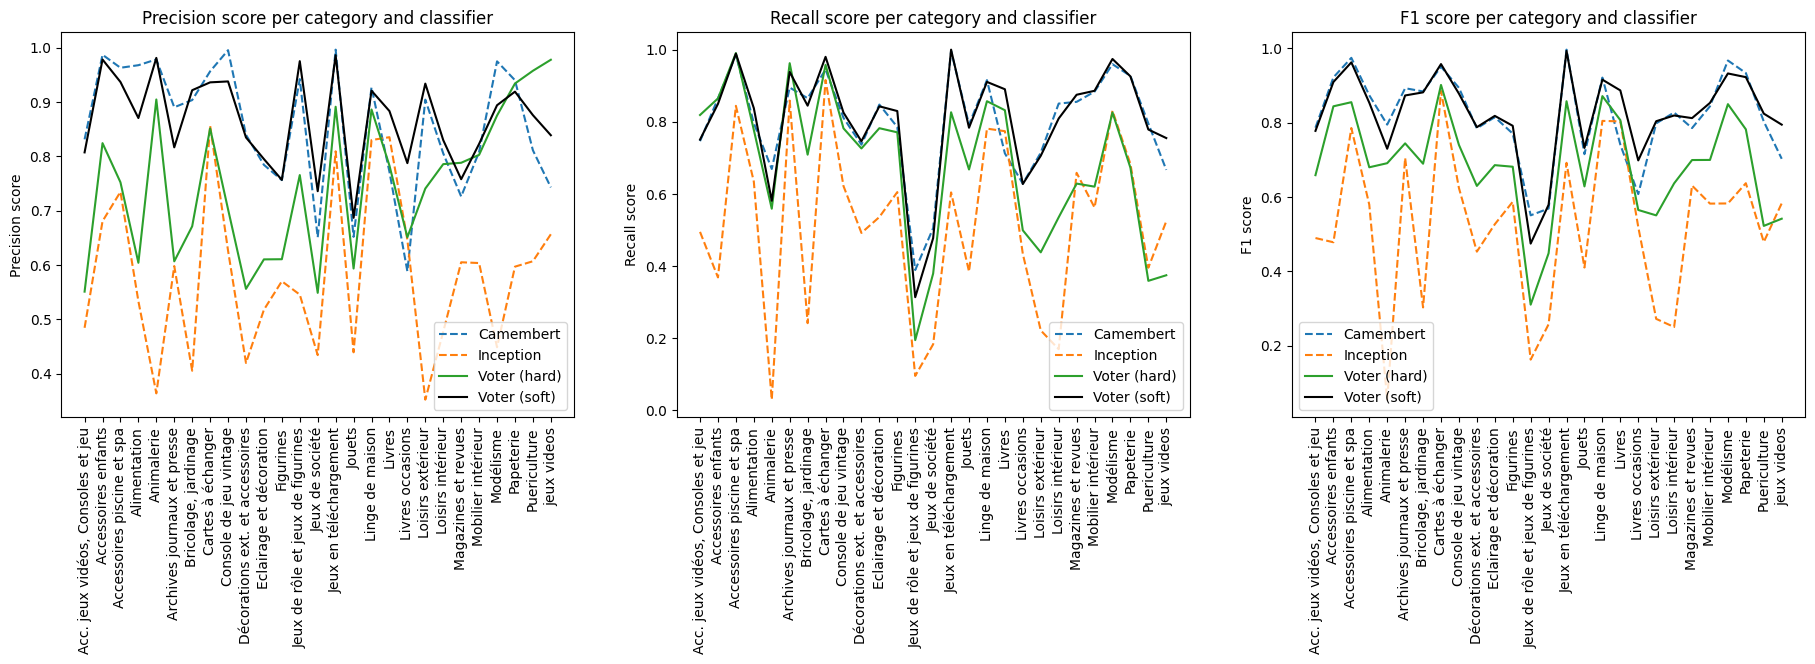

In [ ]:
scores_to_plot = {
    score_name: {
        mdl_name: score_function(y_test, y_pred, average=None)
        for mdl_name, y_pred in (
            ("Camembert", proba_stack.clf_predict("Camembert")),
            ("Inception", proba_stack.clf_predict("Inception")),
            ("Voter (hard)", y_pred_voter_hard),
            ("Voter (soft)", y_pred_voter_soft),
        )
    }
    for score_name, score_function in (
        ("Precision", precision_score),
        ("Recall", recall_score),
        ("F1", f1_score)
    )
}

plot_scores_per_cat_mdl(
    unique_categories,
    scores_to_plot,
    kwargs_per_mdl={"Camembert": {"linestyle": "--"}, "Inception": {"linestyle": "--"}, "Voter (soft)": {"color": "black"}}
)


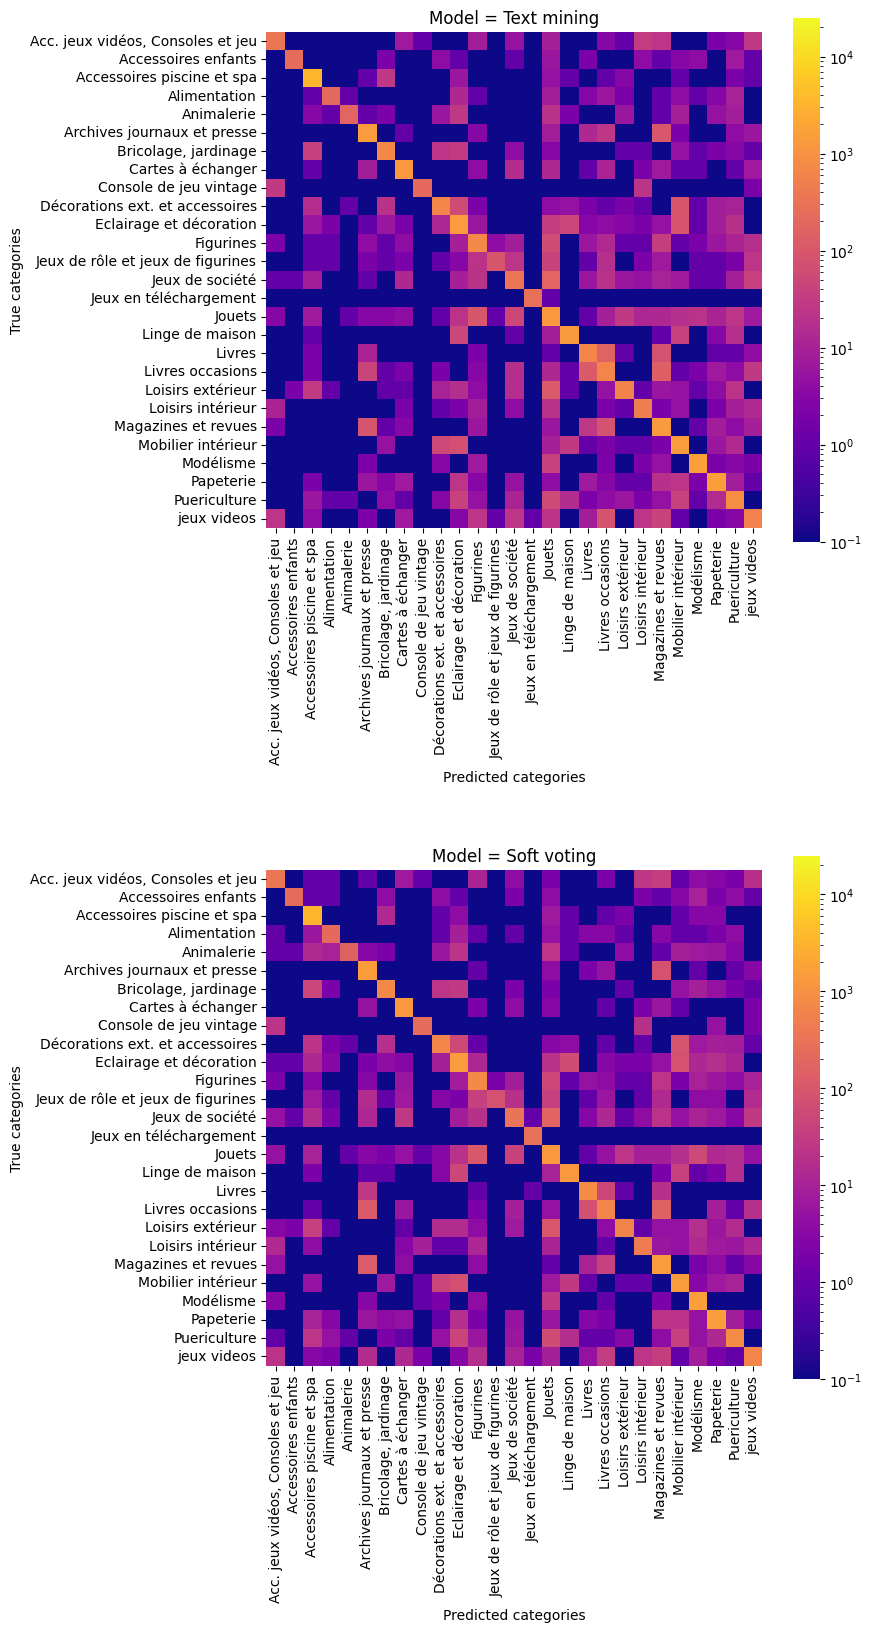

In [ ]:
plot_confusion_matrices(y_test, {"Text mining": proba_stack.clf_predict("Camembert"), "Soft voting": y_pred_voter_soft}, ordered_categories=unique_categories)

In [ ]:
#proba_stack = PredictProbaStack()
#proba_stack = joblib.load(os.path.join(MODEL_RESULTS_DIR, "voter_camembert_inception_test_stack.joblib"))
#y_pred_voter_soft = proba_stack.predict("soft")
from sklearn.metrics import classification_report

# Afficher le rapport de classification
print(classification_report(y_test, y_pred_voter_soft))

                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.81      0.75      0.78       469
              Accessoires enfants       0.98      0.85      0.91       266
       Accessoires piscine et spa       0.94      0.99      0.96      3369
                     Alimentation       0.87      0.84      0.85       265
                       Animalerie       0.98      0.58      0.73       272
      Archives journaux et presse       0.82      0.94      0.87      1571
             Bricolage, jardinage       0.92      0.84      0.88       824
                Cartes à échanger       0.94      0.98      0.96      1305
           Console de jeu vintage       0.94      0.83      0.88       275
  Décorations ext. et accessoires       0.83      0.75      0.79       854
          Eclairage et décoration       0.80      0.84      0.82      1648
                        Figurines       0.76      0.83      0.79       881
Jeux de rôle et jeux de 

### *Bilan*

L'apport d'un système de vote entre le classificateur le plus performant en text mining et le plus performant en computer vision est très limité. En termes d'accuracy pondérée sur l'ensemble des données de test, le gain s'élève à 0.6 point environ.

Le vote en mode "dur" (vote par majorité) donne des résultats décevants, avec des scores inférieurs au modèle de text mining (Camembert) pour presque toutes les catégories de produit. Seul le mode "doux" (passant par la moyenne inter-modèle des probabilités de prédiction) est exploitable, avec des résultats très proches de ceux du modèle de text mining (Camembert). Un peu plus précisément, le vote doux se montre très légèrement moins efficace que le text mining seul sur les classes les mieux prédites et modérément meilleur pour les classes les moins bien prédites.

En résumé, les intérêts relatifs entre le système de vote en mode doux et le text mining seul peuvent prêter à discussion. Le premier assure une robustesse un peu plus grande que le second, mais au prix d'un temps de calcul multiplié par quasiment 5.

Reste la possibilité de donner des poids différents aux deux modèles intégrés au système de vote pour améliorer encore les résultats.

### Effet des poids relatifs entre classificateurs

In [ ]:
#proba_stack = joblib.load(os.path.join(MODEL_RESULTS_DIR, "voter_camembert_inception_test_stack.joblib"))

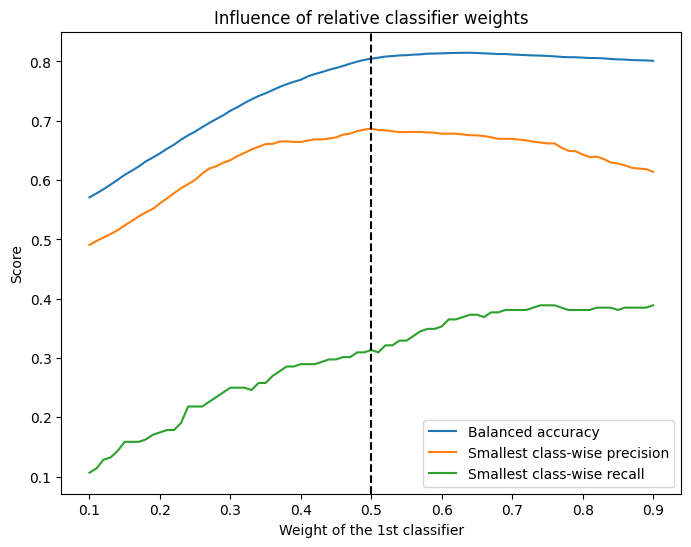

In [ ]:
weights_1st_classifier = np.arange(0.1, 0.90001, 0.01)
balanced_accuracies = []
min_precisions = []
min_recalls = []

for w in weights_1st_classifier:
  y_pred_for_w = proba_stack.predict("soft", [w, 1. - w])
  balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred_for_w))
  min_precisions.append(np.array(precision_score(y_test, y_pred_for_w, average=None)).min())
  min_recalls.append(np.array(recall_score(y_test, y_pred_for_w, average=None)).min())

balanced_accuracies = np.array(balanced_accuracies)
min_precisions = np.array(min_precisions)
min_recalls = np.array(min_recalls)

plt.figure(figsize=(8, 6))
plt.plot(weights_1st_classifier, balanced_accuracies, label="Balanced accuracy")
plt.plot(weights_1st_classifier, min_precisions, label="Smallest class-wise precision")
plt.plot(weights_1st_classifier, min_recalls, label="Smallest class-wise recall")
plt.axvline(x=0.5, linestyle="--", color="black")
plt.xlabel("Weight of the 1st classifier")
plt.ylabel("Score")
plt.title("Influence of relative classifier weights")
plt.legend();

In [ ]:
weights_1st_classifier[balanced_accuracies.argmax()], weights_1st_classifier[min_precisions.argmax()], weights_1st_classifier[min_recalls.argmax()]


(0.6399999999999997, 0.4999999999999998, 0.7399999999999997)

Dans le graphe ci-dessus, nous pouvons voir l'influence du poids attribué au premier classificateur (text mining/CamemBERT) sur l'accuracy pondérée et sur les plus petit scores de précision et de rappel parmi les différentes classes prédites. Il ressort qu'accorder un poids d'au moins 50% au modèle CamemBERT est indispensable pour justifier l'utilisation du système de vote. Un peu plus dans le détail :

*   un poids de 50% donné à CamemBERT assure une maximisation du score de précision pour la catégorie de produits la moins bien prédite
*   un poids de 74% produit le même effet pour le score de rappel
*   un poids de 64%, lui, maximise l'accuracy équilibrée

Nous pouvons examiner les résultats avec un poids de 65% pour CamemBERT et 35% pour InceptionV3.

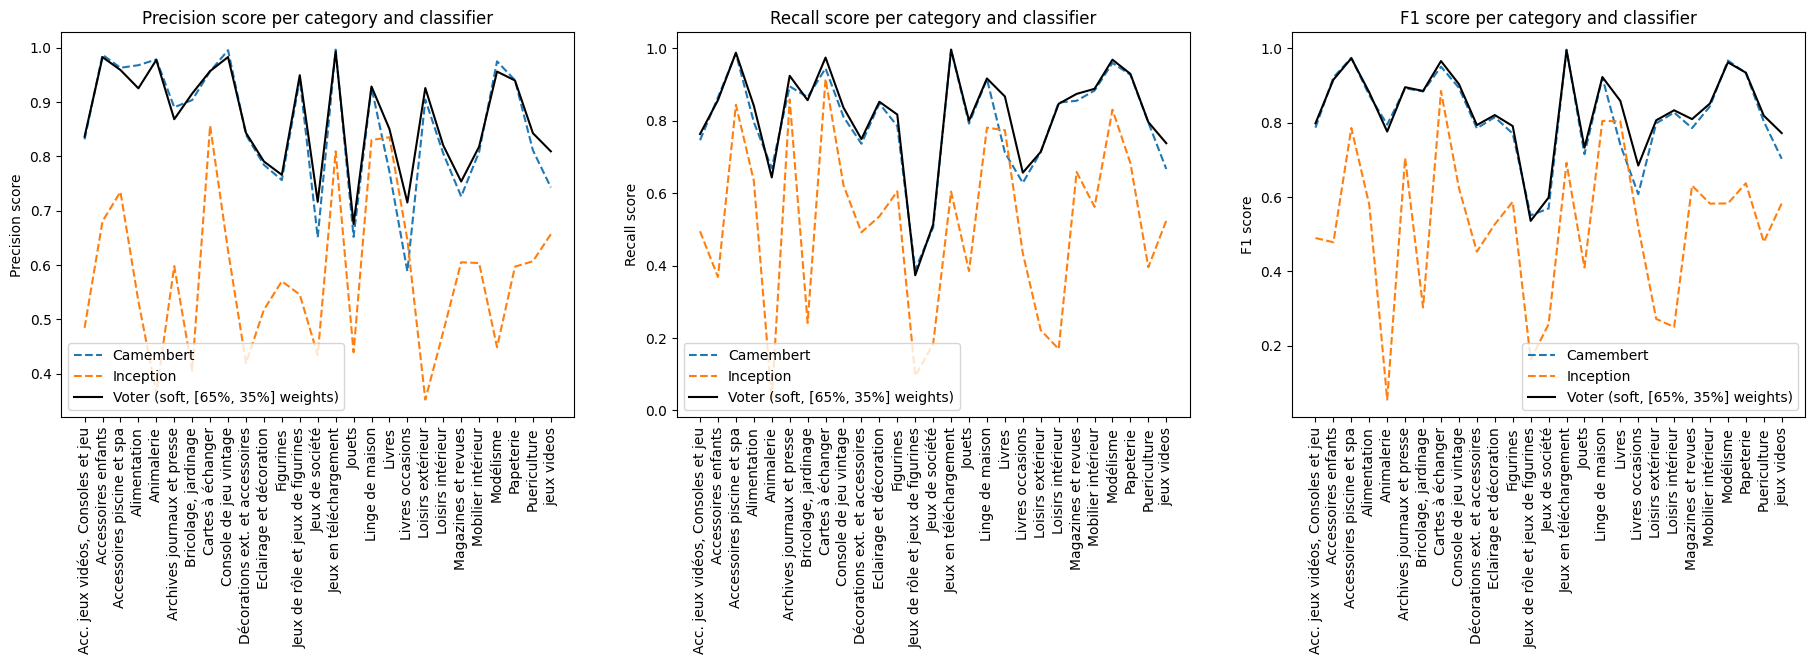

In [ ]:
y_pred_soft_65_35 = proba_stack.predict("soft", [0.65, 0.35])

scores_to_plot = {
    score_name: {
        mdl_name: score_function(y_test, y_pred, average=None)
        for mdl_name, y_pred in (
            ("Camembert", proba_stack.clf_predict("Camembert")),
            ("Inception", proba_stack.clf_predict("Inception")),
            ("Voter (soft, [65%, 35%] weights)", y_pred_soft_65_35),
        )
    }
    for score_name, score_function in (
        ("Precision", precision_score),
        ("Recall", recall_score),
        ("F1", f1_score)
    )
}

plot_scores_per_cat_mdl(
    unique_categories,
    scores_to_plot,
    kwargs_per_mdl={"Camembert": {"linestyle": "--"}, "Inception": {"linestyle": "--"}, "Voter (soft, [65%, 35%] weights)": {"color": "black"}}
)

In [ ]:
balanced_accuracy_score(y_test, y_pred_soft_65_35)

0.8142681757943291

In [ ]:
print(classification_report(y_test, y_pred_soft_65_35))

                                   precision    recall  f1-score   support

Acc. jeux vidéos, Consoles et jeu       0.84      0.76      0.80       469
              Accessoires enfants       0.98      0.86      0.92       266
       Accessoires piscine et spa       0.96      0.99      0.97      3369
                     Alimentation       0.93      0.84      0.88       265
                       Animalerie       0.98      0.64      0.78       272
      Archives journaux et presse       0.87      0.92      0.90      1571
             Bricolage, jardinage       0.92      0.86      0.89       824
                Cartes à échanger       0.96      0.97      0.97      1305
           Console de jeu vintage       0.98      0.84      0.90       275
  Décorations ext. et accessoires       0.84      0.75      0.79       854
          Eclairage et décoration       0.79      0.85      0.82      1648
                        Figurines       0.77      0.82      0.79       881
Jeux de rôle et jeux de 

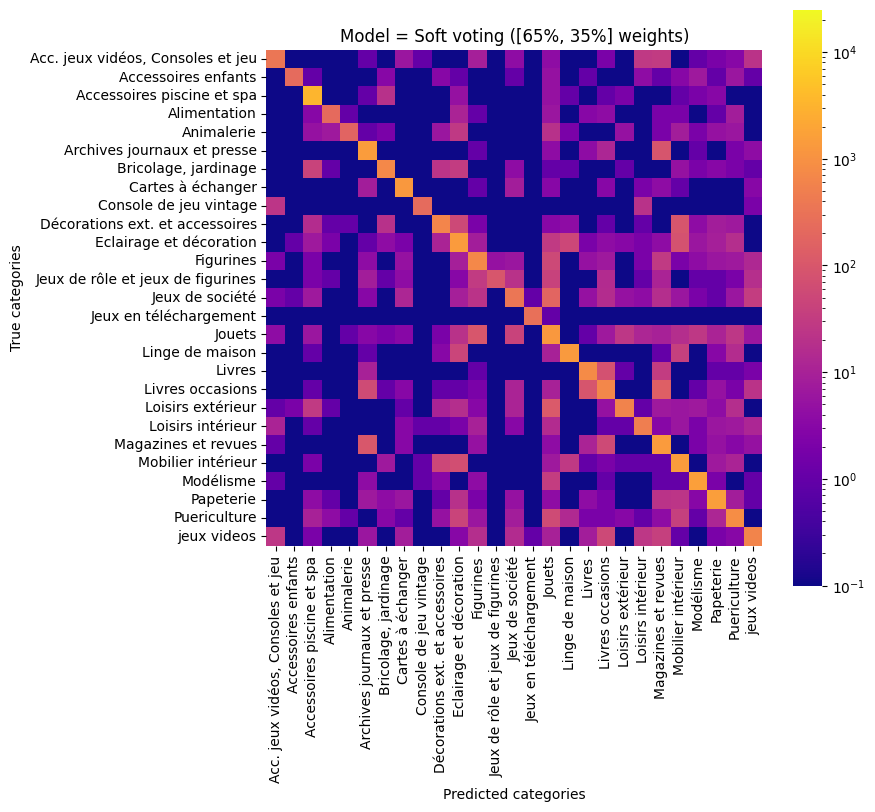

In [ ]:
plot_confusion_matrices(y_test, {"Soft voting ([65%, 35%] weights)": y_pred_soft_65_35}, ordered_categories=unique_categories)

L'utilisation de poids différents entre text mining et computer vision a un bénéfice tangible. En attribuant 65% au modèle CamemBERT et 35% au modèle InceptionV3, l'accuracy équilibrée passe à 81% et est meilleure d'un point qu'avec des poids égaux entre eux. On constate alors une légère sous-performance par rapport à CamemBERT seul pour quelques catégories de produits (précision pour "Alimentation" notamment), mais ceci est largement compensé par un gain de robustesse sur les catégories les plus difficiles à prédire.

En résumé, en termes d'approche bi-modale simple, un voteur type "doux" composé des modèles CamemBERT et InceptionV3 avec des poids respectifs de 65% et 35% semble pertinent.